In [1]:
#IMPORTS
import tensorflow as tf 
import keras
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv1D, GlobalAveragePooling1D, Flatten, Dense, Concatenate, Dropout, LSTM, BatchNormalization
from keras.layers import MaxPooling1D
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split, StratifiedKFold,LeaveOneOut
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
from scipy.interpolate import interp1d
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.layers import LeakyReLU

In [2]:
def get_dataframes(path):
    dataframes = []
    df_names = {}
    # Loop to read and convert .csv files to pandas df, then appended to dataframes list
    for filename in os.listdir(path):
        if os.path.isfile(os.path.join(path, filename)) and filename.endswith('.csv'): #check if .csv file
            # Extract the filename without the .csv extension
            name = filename.split('.')[0]
            # Add the name as a key to the dictionary with an empty value
            df_names[name] = None
            df = pd.read_csv(os.path.join(path, filename),skiprows=9, delimiter=';') #coverts to pandas df and removing first 9 rows
            dataframes.append(df) #adding to dataframes list
    return dataframes,df_names

def preprocess_dataframes(data):
    # Extracting relevant features
    datasets = [df[["P Raw", "T Raw", "BR Raw"]].values for df in data]
    
    # Padding to match all time series lengths
    max_len = max([len(ds) for ds in datasets])
    padded_datasets = [np.pad(ds, ((0, max_len - len(ds)), (0, 0)), 'constant') for ds in datasets]
    
    # Stack datasets
    stacked_data = np.stack(padded_datasets, axis=0)
    return stacked_data

def time_warp(series, factor):
    """
    Warps a time series with a given factor.
    """
    warped_series = np.zeros_like(series)
    for i in range(series.shape[1]):  # Iterate over each feature channel
        stretched = np.interp(np.linspace(0, len(series), int(factor*len(series))), np.arange(len(series)), series[:, i])
        if factor > 1:  # If stretching the series
            warped_series[:, i] = stretched[:len(series)]
        else:  # If compressing the series
            warped_series[:, i] = np.pad(stretched, (0, len(series) - len(stretched)), 'edge')
    return warped_series

def window_slice(series, window_size):
    """
    Returns a sliced time series of a given window size.
    """
    start = np.random.randint(0, len(series) - window_size + 1)
    return series[start:start + window_size]

In [3]:
# Read Excel file containing labelled data
labelled_data = pd.read_excel(r'/Users/sujayan_vanithas/Pictures/CODING/DISS_PROJECT/Statistic featuress.xlsx')

# Remove first empty row and part to part gap column 
labelled_data.drop(index=0, columns=labelled_data.columns[7], inplace=True)

path_A = r'/Users/sujayan_vanithas/Pictures/CODING/DISS_PROJECT/Signals - Dataset A' #chosen directory containing dataset A
path_B = r'/Users/sujayan_vanithas/Pictures/CODING/DISS_PROJECT/Signals - Dataset B'
path_C = r'/Users/sujayan_vanithas/Pictures/CODING/DISS_PROJECT/Signals - Dataset C'

# Get the DataFrames from the CSV files
dataset_A, A_filenames = get_dataframes(path_A)
dataset_B, B_filenames = get_dataframes(path_B)
dataset_C, C_filenames = get_dataframes(path_C)

# preprocess raw data into structured stacked array
stacked_dataA = preprocess_dataframes(dataset_A)
stacked_dataB = preprocess_dataframes(dataset_B)
stacked_dataC = preprocess_dataframes(dataset_C)

print(stacked_dataA.shape, stacked_dataB.shape, stacked_dataC.shape)

(46, 20001, 3) (14, 15001, 3) (86, 20001, 3)


In [4]:
#LABELLED DATA SORTING (STATS FEATURES)

ordered_signal_ids = [int(key) for key in A_filenames.keys()]

# Set the Signal_ID column as the index and then reindex based on the order_of_signal_ids
reordered_labelled_data = labelled_data.set_index('Signal ID').reindex(ordered_signal_ids).reset_index()

# Drop the 'Signal ID', 'Laser Power' columns
labelled_data_sorted = reordered_labelled_data.drop(columns=['Signal ID','Laser Power [W]'])

# Extract mean and standard deviation for each signal in stacked_dataB
mean_SP_dataB = np.mean(stacked_dataB[:,:,0], axis=1)
std_SP_dataB = np.std(stacked_dataB[:,:,0], axis=1)

mean_ST_dataB = np.mean(stacked_dataB[:,:,1], axis=1)
std_ST_dataB = np.std(stacked_dataB[:,:,1], axis=1)

mean_SR_dataB = np.mean(stacked_dataB[:,:,2], axis=1)
std_SR_dataB = np.std(stacked_dataB[:,:,2], axis=1)

stats_dataB = np.stack([mean_SP_dataB, std_SP_dataB, mean_ST_dataB, std_ST_dataB, mean_SR_dataB, std_SR_dataB], axis=1)

# Extract mean and standard deviation for each signal in stacked_dataC
mean_SP_dataC = np.mean(stacked_dataC[:,:,0], axis=1)
std_SP_dataC = np.std(stacked_dataC[:,:,0], axis=1)

mean_ST_dataC = np.mean(stacked_dataC[:,:,1], axis=1)
std_ST_dataC = np.std(stacked_dataC[:,:,1], axis=1)

mean_SR_dataC = np.mean(stacked_dataC[:,:,2], axis=1)
std_SR_dataC = np.std(stacked_dataC[:,:,2], axis=1)

stats_dataC = np.stack([mean_SP_dataC, std_SP_dataC, mean_ST_dataC, std_ST_dataC, mean_SR_dataC, std_SR_dataC], axis=1)

# Split the data into features and labels
X_raw = stacked_dataA
X_stats = labelled_data_sorted[['Mean SP [V]', 'St Dev SP [V]', 'Mean ST [V]', 'St Dev ST [V]', 'Mean SR [V]', 'St Dev SR [V]']].values
y = labelled_data_sorted['Label'].values

X_raw.shape

(46, 20001, 3)

In [5]:
def evaluate_model(model_fn, X_raw, X_stats, y, n_folds=5):
    kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

    # Initialize lists to store metrics
    confusion_matrices = []
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    overall_loss_per_fold = []
    overall_val_loss_per_fold = []
    overall_train_accuracy_per_fold = []
    overall_val_accuracy_per_fold = []

    
    for train_idx, val_idx in kfold.split(X_raw, y):
        # Split the data
        X_raw_train, X_raw_val = X_raw[train_idx], X_raw[val_idx]
        X_stats_train, X_stats_val = X_stats[train_idx], X_stats[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        #DATA AUGMENTATION STAGE
        augmented_data = []
        augmented_labels = []

        # Maximum and minimum window sizes for augmentation
        max_window_size = 20000
        min_window_size = 10000

        # Number of augmented samples per training sample
        num_augmentations_per_sample = 3

        for i in range(len(X_raw_train)):
            label = y_train[i]
            for _ in range(num_augmentations_per_sample):
                if label == "SW": 
                    # Apply specific augmentations for SW class
                    warp_factor = np.random.uniform(0, 2) # 0.7
                    random_window_size = np.random.randint(1000, 20000 + 1) # Experiment with these values
                elif label == "OP":
                    # Apply specific augmentations for OP class
                    warp_factor = np.random.uniform(0, 0.5) # Experiment with these values
                    random_window_size = np.random.randint(1000, 20000 + 1) # 7000 20000
                else:
                    # Apply general augmentations for LoC classes
                    warp_factor = np.random.uniform(0, 1)
                    random_window_size = np.random.randint(min_window_size, max_window_size + 1)

                warped_data = time_warp(X_raw_train[i], factor=warp_factor)
                sliced_data = window_slice(warped_data, random_window_size)

                # Padding to maintain original shape (20001 time steps)
                sliced_data_padded = np.pad(sliced_data, ((0, X_raw_train.shape[1] - random_window_size), (0, 0)), 'edge')

                augmented_data.append(sliced_data_padded)
                augmented_labels.append(y_train[i])

        # Convert lists to numpy arrays
        augmented_data = np.array(augmented_data)
        augmented_labels = np.array(augmented_labels)


        # Extract mean and standard deviation for each signal in augmented_data
        mean_SP_augmented = np.mean(augmented_data[:,:,0], axis=1)
        std_SP_augmented = np.std(augmented_data[:,:,0], axis=1)

        mean_ST_augmented = np.mean(augmented_data[:,:,1], axis=1)
        std_ST_augmented = np.std(augmented_data[:,:,1], axis=1)

        mean_SR_augmented = np.mean(augmented_data[:,:,2], axis=1)
        std_SR_augmented = np.std(augmented_data[:,:,2], axis=1)

        # Stack them to form the statistical features for augmented_data
        stats_augmented = np.stack([mean_SP_augmented, std_SP_augmented, mean_ST_augmented, std_ST_augmented, mean_SR_augmented, std_SR_augmented], axis=1)

        #ONE_HOT ENCODE THE LABELS OF ALL THE LABELLED DATASETS

        # Create the labels encoder
        encoder = OneHotEncoder(sparse=False)

        # Fit the encoder on the labels and transform
        y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))
        augmented_labels_encoded = encoder.transform(augmented_labels.reshape(-1, 1))
        y_val_encoded = encoder.transform(y_val.reshape(-1, 1))


        #CONCANTENATE AUGMENTED DATASETs WITH ORGINAL TRAINING SETS
        X_train_augmented = np.concatenate([X_raw_train, augmented_data])
        X_stats_train_augmented = np.concatenate([X_stats_train, stats_augmented], axis=0)

        y_train_augmented = np.concatenate([y_train_encoded, augmented_labels_encoded])


        #Dataset A Normalisation
        mean_raw = np.mean(X_train_augmented, axis=(0, 1))  # mean across samples and time steps
        std_raw = np.std(X_train_augmented, axis=(0, 1))    # std deviation across samples and time steps

        X_train_augmented = (X_train_augmented - mean_raw) / std_raw
        X_raw_val = (X_raw_val - mean_raw) / std_raw

        # Statistical Features DATASET A Normalisation
        mean_stats = np.mean(X_stats_train_augmented, axis=0)
        std_stats = np.std(X_stats_train_augmented, axis=0)

        X_stats_train = (X_stats_train - mean_stats) / std_stats
        X_stats_val = (X_stats_val - mean_stats) / std_stats

        '''currently normalised using statisical features'''

        ########Dataset A Normalisation########### 
        mean_raw_A = np.mean(stacked_dataA, axis=(0, 1))  # mean across samples and time steps
        std_raw_A = np.std(stacked_dataA, axis=(0, 1)) 

        mean_stats_A = np.mean(X_stats, axis=0)
        std_stats_A = np.std(X_stats, axis=0)

        # Normalise stacked_dataB using mean_raw and std_raw from Dataset A
        stacked_dataA_normalised = (stacked_dataA - mean_raw) / std_raw

        # Normalize stats_dataB using mean_stats and std_stats from Dataset A
        stats_dataA_normalised = (X_stats - mean_stats) / std_stats



        ########Dataset B Normalisation########### 
        mean_raw_B = np.mean(stacked_dataB, axis=(0, 1))  # mean across samples and time steps
        std_raw_B = np.std(stacked_dataB, axis=(0, 1)) 

        mean_stats_B = np.mean(stats_dataB, axis=0)
        std_stats_B = np.std(stats_dataB, axis=0)

        # Normalise stacked_dataB using mean_raw and std_raw from Dataset A
        stacked_dataB_normalised = (stacked_dataB - mean_raw) / std_raw

        # Normalize stats_dataB using mean_stats and std_stats from Dataset A
        stats_dataB_normalised = (stats_dataB - mean_stats) / std_stats

        #########Dataset C Normalisation#########
        mean_raw_C = np.mean(stacked_dataC, axis=(0, 1))  # mean across samples and time steps
        std_raw_C = np.std(stacked_dataC, axis=(0, 1)) 

        mean_stats_C = np.mean(stats_dataC, axis=0)
        std_stats_C = np.std(stats_dataC, axis=0)

        # Normalise stacked_dataB using mean_raw and std_raw from Dataset A
        stacked_dataC_normalised = (stacked_dataC - mean_raw) / std_raw

        # Normalise stats_dataB using mean_stats and std_stats from Dataset A
        stats_dataC_normalised = (stats_dataC - mean_stats) / std_stats

        # Define the model architecture
        model = model_fn(input_shape_raw=(X_train_augmented.shape[1], X_train_augmented.shape[2]), input_shape_stats=(X_stats_train.shape[1],))
        
        # Learning rate schedule
        def scheduler(epoch, lr):
            if epoch < 10:
                return lr
            else:
                return lr * 0.9

        lr_callback = LearningRateScheduler(scheduler)
        
        # Define early stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
    
        # Train the model
        history = model.fit([X_train_augmented, X_stats_train_augmented], y_train_augmented,
                            validation_data=([X_raw_val, X_stats_val], y_val_encoded), 
                            epochs=100,  # set a large number of epochs, early stopping will halt it once necessary
                            batch_size=16,
                            callbacks=[early_stopping,lr_callback],verbose=2)


        # Store loss and val_loss for this fold
        overall_loss_per_fold.append(history.history['loss'])
        overall_val_loss_per_fold.append(history.history['val_loss'])
        overall_train_accuracy_per_fold.append(history.history['accuracy'])
        overall_val_accuracy_per_fold.append(history.history['val_accuracy'])

        # Plot the learning curves
        plt.figure()
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Learning Curves')
        plt.show()

        # Make predictions on the validation set
        predictions_val = model.predict([X_raw_val, X_stats_val])
        decoded_labels_val = encoder.inverse_transform(np.eye(3)[np.argmax(predictions_val, axis=1)])

        # Compute the confusion matrix
        cm = confusion_matrix(y_val, decoded_labels_val)
        confusion_matrices.append(cm)

        # Calculate accuracy, precision, recall, and F1-score
        acc = accuracy_score(y_val, decoded_labels_val)
        prec = precision_score(y_val, decoded_labels_val, average='macro')
        rec = recall_score(y_val, decoded_labels_val, average='macro')
        f1 = f1_score(y_val, decoded_labels_val, average='macro')

        accuracies.append(acc)
        precisions.append(prec)
        recalls.append(rec)
        f1_scores.append(f1)

    # Calculate average metrics
    mean_accuracy = np.mean(accuracies)
    mean_precision = np.mean(precisions)
    mean_recall = np.mean(recalls)
    mean_f1_score = np.mean(f1_scores)

    # Aggregate confusion matrix
    aggregate_confusion_matrix = np.sum(confusion_matrices, axis=0)
    
    # Return overall_loss_per_fold and overall_val_loss_per_fold
    return mean_accuracy, mean_precision, mean_recall, mean_f1_score, aggregate_confusion_matrix, overall_loss_per_fold, overall_val_loss_per_fold, overall_train_accuracy_per_fold, overall_val_accuracy_per_fold, model


In [6]:
def model_v1(input_shape_raw,input_shape_stats):
    # Raw data input
    input_raw = Input(input_shape_raw)
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(input_raw)
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
    x = GlobalAveragePooling1D()(x)

    # Statistical data input
    input_stats = Input(input_shape_stats)
    y = Dense(32, activation='relu')(input_stats)
    y = Dense(32, activation='relu')(y)

    # Merge CNN and dense network outputs
    merged = Concatenate()([x, y])
    z = Dense(64, activation='relu')(merged)
    z = Dense(64, activation='relu')(z)

    # Output layer
    output = Dense(3, activation='softmax')(z)

    # Create and compile model
    optimizer = Adam(learning_rate=0.001)
    model = Model(inputs=[input_raw, input_stats], outputs=output)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def model_v2(input_shape_raw,input_shape_stats):
    # Regularization strength
    l2_lambda = 0.001

    # Raw data input
    input_raw = Input(shape=input_shape_raw)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(l2_lambda))(input_raw)
    x = Dropout(0.5)(x)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(l2_lambda))(x)
    x = Dropout(0.5)(x)
    x = GlobalAveragePooling1D()(x)

    # Statistical data input
    input_stats = Input(shape=input_shape_stats)
    y = Dense(32, activation='relu', kernel_regularizer=l2(l2_lambda))(input_stats)
    y = Dropout(0.5)(y)
    y = Dense(32, activation='relu', kernel_regularizer=l2(l2_lambda))(y)
    y = Dropout(0.5)(y)

    # Merge CNN and dense network outputs
    merged = Concatenate()([x, y])
    z = Dense(64, activation='relu', kernel_regularizer=l2(l2_lambda))(merged)
    z = Dropout(0.5)(z)
    z = Dense(64, activation='relu', kernel_regularizer=l2(l2_lambda))(z)

    # Output layer
    output = Dense(3, activation='softmax')(z)

    # Create and compile model
    optimizer = Adam(learning_rate=0.001)
    model = Model(inputs=[input_raw, input_stats], outputs=output)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def model_v3(input_shape_raw, input_shape_stats):
    # Regularization strength
    l2_lambda = 6.600318609580986e-05

    # Dropout rate
    dropout_rate = 0.3

    # Number of filters
    num_filters = 96

    # Raw data input
    input_raw = Input(shape=input_shape_raw)
    x = Conv1D(filters=num_filters, kernel_size=3, activation='relu', kernel_regularizer=l2(l2_lambda))(input_raw)
    x = Dropout(dropout_rate)(x)
    x = Conv1D(filters=num_filters, kernel_size=3, activation='relu', kernel_regularizer=l2(l2_lambda))(x)
    x = Dropout(dropout_rate)(x)
    x = GlobalAveragePooling1D()(x)

    # Statistical data input
    input_stats = Input(shape=input_shape_stats)
    y = Dense(32, activation='relu', kernel_regularizer=l2(l2_lambda))(input_stats)
    y = Dropout(dropout_rate)(y)
    y = Dense(32, activation='relu', kernel_regularizer=l2(l2_lambda))(y)
    y = Dropout(dropout_rate)(y)

    # Merge CNN and dense network outputs
    merged = Concatenate()([x, y])
    z = Dense(64, activation='relu', kernel_regularizer=l2(l2_lambda))(merged)
    z = Dropout(dropout_rate)(z)
    z = Dense(64, activation='relu', kernel_regularizer=l2(l2_lambda))(z)

    # Output layer
    output = Dense(3, activation='softmax')(z)

    # Create and compile model
    optimizer = Adam(learning_rate=0.001)
    model = Model(inputs=[input_raw, input_stats], outputs=output)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def model_v4(input_shape_raw, input_shape_stats):
    # Regularization strength
    l2_lambda = 0.005

    # Raw data input
    input_raw = Input(shape=input_shape_raw)

    # Convolutional layers
    x = Conv1D(filters=48, kernel_size=3, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(l2_lambda))(input_raw)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Conv1D(filters=96, kernel_size=3, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(l2_lambda))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = GlobalAveragePooling1D()(x)

    # Statistical data input
    input_stats = Input(shape=input_shape_stats)
    y = Dense(48, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(l2_lambda))(input_stats)
    y = BatchNormalization()(y)
    y = Dropout(0.3)(y)

    y = Dense(24, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(l2_lambda))(y)
    y = BatchNormalization()(y)
    y = Dropout(0.3)(y)

    # Merge CNN and dense network outputs
    merged = Concatenate()([x, y])
    z = Dense(96, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(l2_lambda))(merged)
    z = BatchNormalization()(z)
    z = Dropout(0.3)(z)

    z = Dense(48, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(l2_lambda))(z)

    # Output layer
    output = Dense(3, activation='softmax')(z)

    # Create and compile model
    optimizer = Adam(learning_rate=0.001)
    model = Model(inputs=[input_raw, input_stats], outputs=output)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def model_v5(input_shape_raw, input_shape_stats):
    leaky_relu = LeakyReLU(alpha=0.1)
    # Regularization strength
    l2_lambda = 0.003

    # Raw data input
    input_raw = Input(shape=input_shape_raw)

    # Convolutional layers
    x = Conv1D(filters=64, kernel_size=3, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(l2_lambda))(input_raw)
    x = leaky_relu(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Conv1D(filters=128, kernel_size=3, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(l2_lambda))(x)
    x = leaky_relu(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Conv1D(filters=64, kernel_size=3, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(l2_lambda))(x)
    x = leaky_relu(x)
    x = GlobalAveragePooling1D()(x)

    # Statistical data input
    input_stats = Input(shape=input_shape_stats)
    y = Dense(64, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(l2_lambda))(input_stats)
    y = BatchNormalization()(y)
    y = Dropout(0.2)(y)

    y = Dense(32, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(l2_lambda))(y)
    y = BatchNormalization()(y)
    y = Dropout(0.2)(y)

    # Merge CNN and dense network outputs
    merged = Concatenate()([x, y])
    z = Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(l2_lambda))(merged)
    z = BatchNormalization()(z)
    z = Dropout(0.2)(z)

    z = Dense(64, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(l2_lambda))(z)

    # Output layer
    output = Dense(3, activation='softmax')(z)

    # Create and compile model
    optimizer = Adam(learning_rate=0.001)
    model = Model(inputs=[input_raw, input_stats], outputs=output)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [18]:
input_shape_raw = (20001, 3)
input_shape_stats = (6,)
model1 = model_v5(input_shape_raw, input_shape_stats)
print("Model v5 Summary:")
model1.summary()

Model v5 Summary:
Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 20001, 3)]   0           []                               
                                                                                                  
 conv1d_21 (Conv1D)             (None, 19999, 64)    640         ['input_21[0][0]']               
                                                                                                  
 leaky_re_lu_1 (LeakyReLU)      multiple             0           ['conv1d_21[0][0]',              
                                                                  'conv1d_22[0][0]',              
                                                                  'conv1d_23[0][0]']              
                                                                         

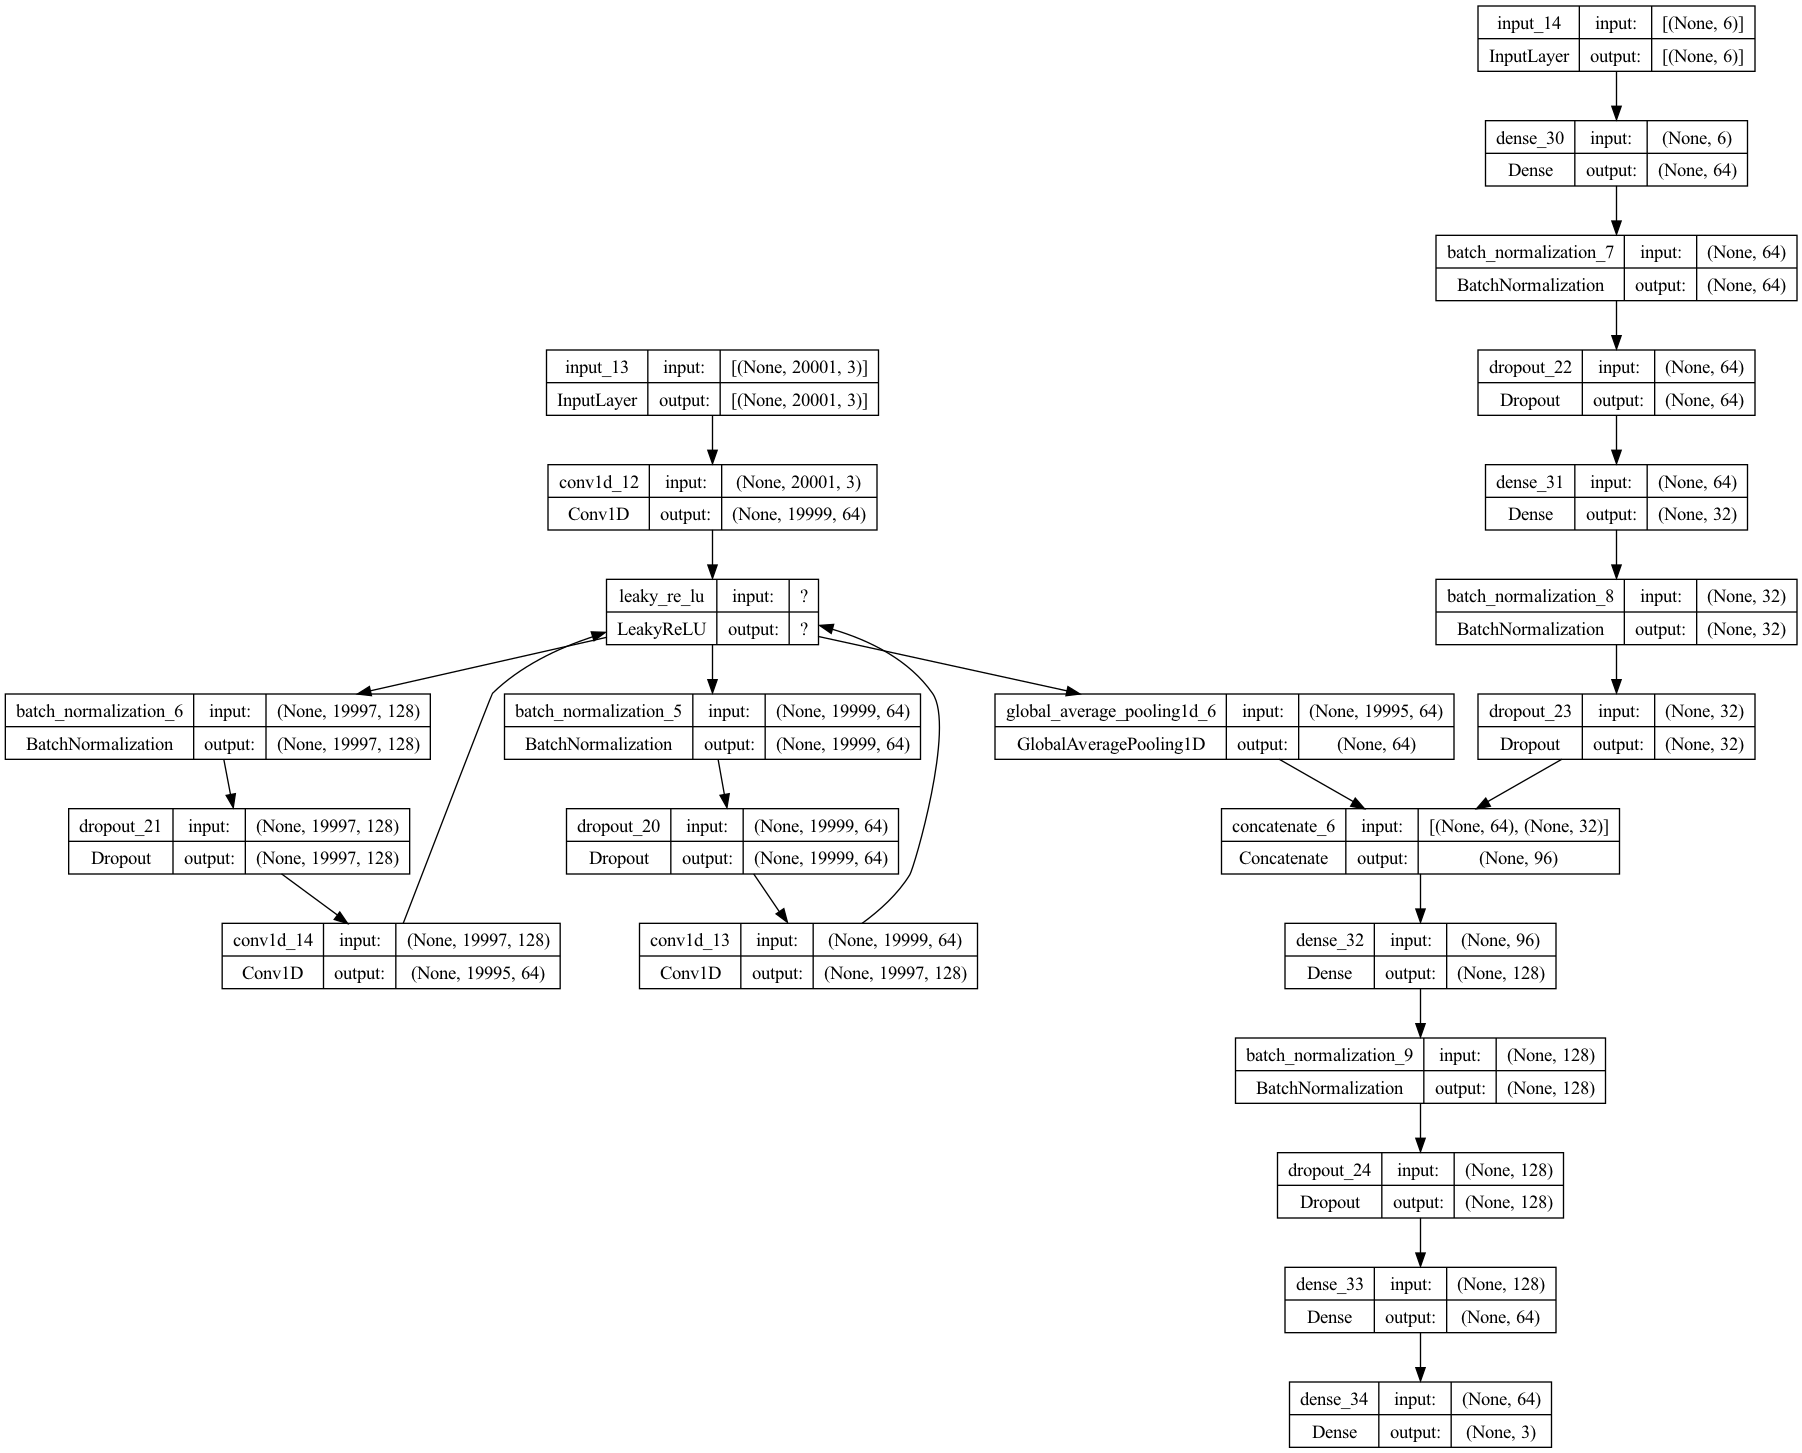

In [14]:
from keras.utils.vis_utils import plot_model

# Assuming model_v1 is already defined and compiled
model = model_v5(input_shape_raw, input_shape_stats)

# Plot the model
plot_model(model, to_file='model_v5.png', show_shapes=True, show_layer_names=True)

In [ ]:
models = [model_v1, model_v2, model_v3, model_v4, model_v5]
results = []

# Iterate over models
for i, model_fn in enumerate(models):
    # Evaluate the model
    mean_accuracy, mean_precision, mean_recall, mean_f1_score, aggregate_confusion_matrix, overall_loss_per_fold, overall_val_loss_per_fold, overall_train_accuracy_per_fold, overall_val_accuracy_per_fold, trained_model = evaluate_model(model_fn, X_raw, X_stats, y)
    
    # Collect results
    results.append((mean_accuracy, mean_precision, mean_recall, mean_f1_score, aggregate_confusion_matrix, overall_loss_per_fold, overall_val_loss_per_fold, overall_train_accuracy_per_fold, overall_val_accuracy_per_fold))
    
    # Calculate the coefficient of variation for validation accuracies
    val_accuracies_per_fold = [np.mean(acc) for acc in overall_val_accuracy_per_fold]
    mean_val_accuracy = np.mean(val_accuracies_per_fold)
    std_val_accuracy = np.std(val_accuracies_per_fold)
    coefficient_of_variation = std_val_accuracy / mean_val_accuracy if mean_val_accuracy != 0 else 0
    
    print(f'Coefficient of Variation for model_v{i+1}: {coefficient_of_variation:.4f}')
    print('-' * 50)

In [ ]:
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#FFB6C1', '#ADD8E6', '#98FB98', '#F0E68C', '#D8BFD8', '#FFE4B5']

for i, metric_name in enumerate(metrics_names):
    bar_values = [result[i] for result in results]
    bars = plt.bar(range(len(models)), bar_values, color=[colors[j % len(colors)] for j in range(len(models))])
    plt.xticks(range(len(models)), [f'model_v{i+1}' for i in range(len(models))])
    plt.ylabel(metric_name)
    plt.title(f'Comparison of {metric_name}')

    # Add the values at the top of each bar
    for bar, value in zip(bars, bar_values):
        plt.text(bar.get_x() + bar.get_width() / 2 - 0.15,
                    bar.get_height() - 0.05,
                    f'{value:.2f}',
                    ha='center',
                    color='black',
                    fontsize=9)

    plt.show()

    # Print the results for each model
    print(f'{metric_name} results for each model:')
    for j, model_name in enumerate([f'model_v{k+1}' for k in range(len(models))]):
        print(f'{model_name}: {bar_values[j]:.4f}')
        print('\n' + '-'*50 + '\n')


# Plot average loss and accuracy learning curves per model
for i, result in enumerate(results):
    overall_loss_per_fold, overall_val_loss_per_fold, overall_train_accuracy_per_fold, overall_val_accuracy_per_fold = result[5], result[6], result[7], result[8]
    
    mean_loss_per_epoch = np.mean(overall_loss_per_fold, axis=0)
    mean_val_loss_per_epoch = np.mean(overall_val_loss_per_fold, axis=0)
    mean_train_accuracy_per_epoch = np.mean(overall_train_accuracy_per_fold, axis=0)
    mean_val_accuracy_per_epoch = np.mean(overall_val_accuracy_per_fold, axis=0)
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(mean_loss_per_epoch, label='Training Loss')
    plt.plot(mean_val_loss_per_epoch, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'model_v{i+1} - Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(mean_train_accuracy_per_epoch, label='Training Accuracy')
    plt.plot(mean_val_accuracy_per_epoch, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'model_v{i+1} - Accuracy')
    
    plt.show()

for i, result in enumerate(results):
    aggregate_confusion_matrix = result[4]
    sns.heatmap(aggregate_confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['LoC', 'OP', 'SW'], yticklabels=['LoC', 'OP', 'SW'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for model_v{i+1}')
    plt.show()
    print(aggregate_confusion_matrix)


In [ ]:
for i, metric_name in enumerate(metrics_names):
    bar_values = [result[i] for result in results]
    bars = plt.bar(range(len(models)), bar_values, )
    plt.xticks(range(len(models)), [f'model_v{i+1}' for i in range(len(models))])
    plt.ylabel(metric_name)
    plt.title(f'Comparison of {metric_name}')

    # Add the values at the top of each bar
    for bar, value in zip(bars, bar_values):
        plt.text(bar.get_x() + bar.get_width() / 2 - 0.15,
                 bar.get_height() - 0.05,
                 f'{value:.2f}',
                 ha='center',
                 color='black',
                 fontsize=9)

    plt.show()

    # Print the results for each model
    print(f'{metric_name} results for each model:')
    for j, model_name in enumerate([f'model_v{k+1}' for k in range(len(models))]):
        print(f'{model_name}: {bar_values[j]:.4f}')
        print('\n' + '-'*50 + '\n')


In [ ]:
# Plot average loss and accuracy learning curves per model
for i, result in enumerate(results):
    overall_loss_per_fold, overall_val_loss_per_fold, overall_train_accuracy_per_fold, overall_val_accuracy_per_fold = result[5], result[6], result[7], result[8]
    
    mean_loss_per_epoch = np.mean(overall_loss_per_fold, axis=0)
    mean_val_loss_per_epoch = np.mean(overall_val_loss_per_fold, axis=0)
    mean_train_accuracy_per_epoch = np.mean(overall_train_accuracy_per_fold, axis=0)
    mean_val_accuracy_per_epoch = np.mean(overall_val_accuracy_per_fold, axis=0)
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(mean_loss_per_epoch, label='Training Loss')
    plt.plot(mean_val_loss_per_epoch, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'model_v{i+1} - Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(mean_train_accuracy_per_epoch, label='Training Accuracy')
    plt.plot(mean_val_accuracy_per_epoch, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'model_v{i+1} - Accuracy')
    
    plt.show()